In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [2]:
# !wget --quiet https://github.com/sizhky/torch_snippets.git
!pip install torch_snippets
from torch_snippets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 58.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 65.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 63.2 MB/s eta 0:00:00:00:01
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=13c692ad05c8b4d3e73a7802abad05cb3e57d15a7adc132049fca56764a7fd30
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing
  Attempting uninsta

In [4]:
# from torch_snippets import *
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchinfo import summary
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models, datasets
from xml.etree import ElementTree as et
import torchvision
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.patches as patches
# import utils
import tqdm
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
# from engine import train_one_epoch, evaluate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

# **0. Создаем 2 списка: путей каритнок и путей аннотаций**

In [6]:
brain_scans = []
mask_files = glob.glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

print(brain_scans[:2])
print(mask_files[:2])
print(len(brain_scans))
print(len(mask_files))

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif']
3929
3929


# **1. Смотрим картинки**

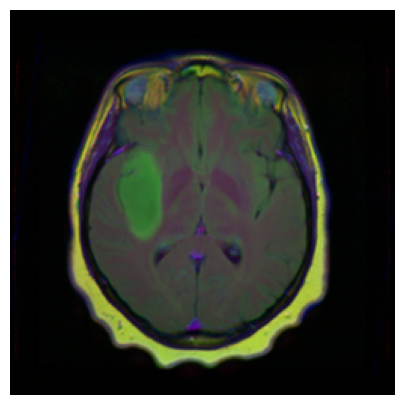

In [8]:
show('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_10.tif', sz=5)

# **2. Смотрим картинки и аннотации**

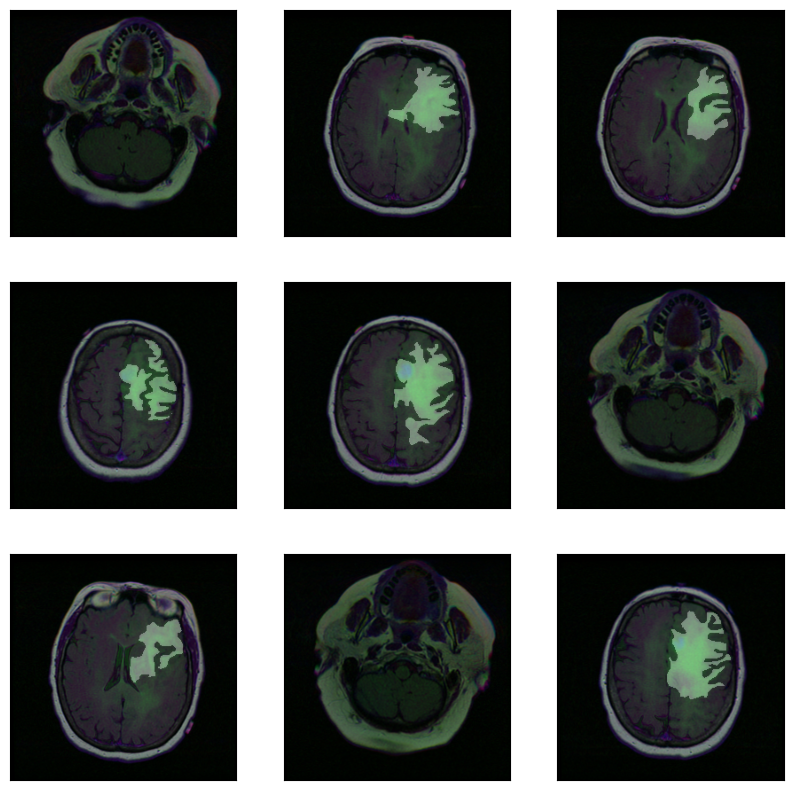

In [9]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=brain_scans[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.3)
    plt.xticks([]), plt.yticks([])
plt.show()

# **3. Смотрим аннотации (изображения)**

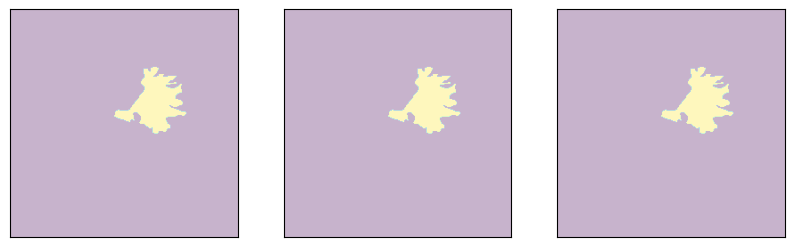

In [10]:
rows,cols=1,3
fig=plt.figure(figsize=(10,10))
for i in np.arange(1,4):
    fig.add_subplot(rows,cols,i)
    msk_path=mask_files[2]
    msk=cv2.imread(msk_path)
    plt.imshow(msk.transpose(-1,0,1)[i-1],alpha=0.3)
    plt.xticks([]), plt.yticks([])
plt.show()

# **4. Смотрим содержимое каналов маски**

In [11]:
# читаем картинку маски, 4меняем каналы местасми на (3,250,250),
an = cv2.imread(mask_files[2], 1).transpose(2,0,1)#/255
r,g,b = an

lst = []
for _ in [0,1,2]:
    k = r,g,b
    h = 'rgb'
    for i in k[_]:
        for j in i:
            if j not in lst: lst.append(j)
    print(f'Значения в канале {h[_]}: {lst}')

Значения в канале r: [0, 255]
Значения в канале g: [0, 255]
Значения в канале b: [0, 255]


# **5. Удаляем пустые маски и соотвествующие картинки, на выходе 2 сортированных списка**

In [13]:
print(brain_scans[:1])
print(mask_files[:1])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif']


In [14]:
len(mask_files)

3929

In [28]:
# функция сортировки:
def sort(elem):
    return elem.split('/')[-1]

In [36]:
annots = []
for ann in Tqdm(mask_files):
    _ann = cv2.imread(ann, 1).transpose(2,0,1)#/255
    r,g,b = _ann
    if 255 not in np.unique(r): continue # отсеиваем маски в которых нет аномалии
    annots.append(ann)
print(f'Количество элементов: {len(annots)}')
print(f'Количество уникальных элементов: {len(set(annots))}')
# print(f'Пример содержимого: {annots[:1]}')

pictures = [i.replace('_mask','') for i in annots]
print(f'Количество элементов: {len(pictures)}')
print(f'Количество уникальных элементов: {len(set(pictures))}')
# print(f'Пример содержимого: {pictures[:1]}')

annots.sort(key=sort)
pictures.sort(key=sort)

100%|██████████| 3929/3929 [00:10<00:00, 381.96it/s]

Количество элементов: 1373
Количество уникальных элементов: 1373
Количество элементов: 1373
Количество уникальных элементов: 1373


In [37]:
pictures[:8]

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18.tif']

In [38]:
annots[:8]

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15_mask.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16_mask.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_mask.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18_mask.tif']

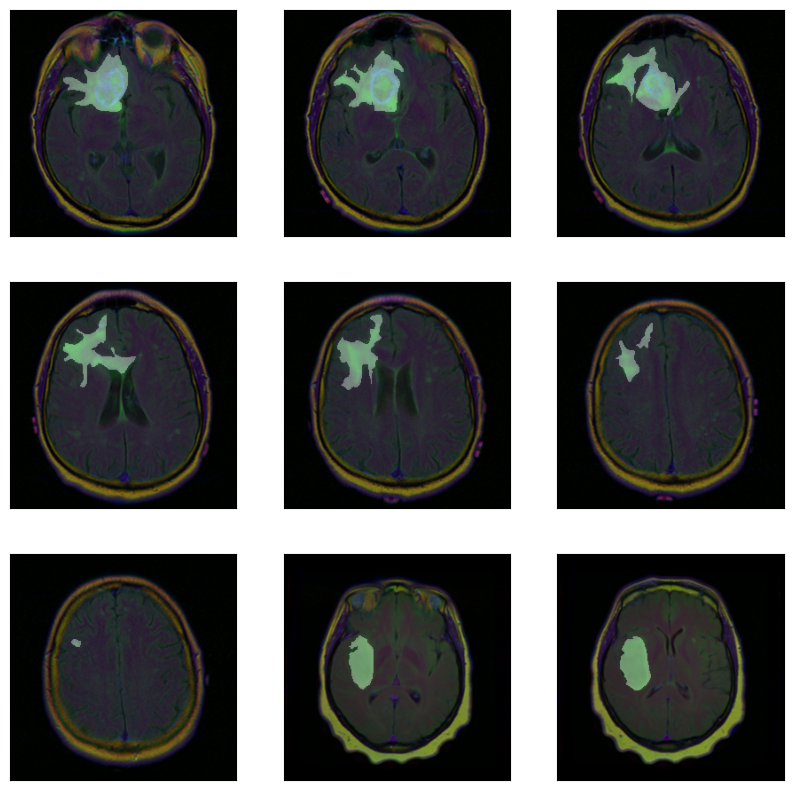

In [39]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=pictures[i]
    msk_path=annots[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.3)
    plt.xticks([]), plt.yticks([])
plt.show()

**как видим - отсутствуют пустые маски!!!**

# **6. Создаем dataframe**

In [40]:
name_col = ['pictures', 'annotations']
lst = pictures, annots
df = pd.DataFrame(np.column_stack(lst), columns = name_col)
print(df.iloc[0,0])
print(df.iloc[0,1])

../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif


In [41]:
df.shape

(1373, 2)

In [44]:
# попарно выводим первый и второй столбец df
for _ in np.arange(4):
    print(df.iloc[_,0])
    print(df.iloc[_,1])

../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif


In [42]:
df.head(5)

,pictures,annotations
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...


# **7. train_test_split**

In [45]:
# Разбивка данных на основе столбца с именами картинок в df
from sklearn.model_selection import train_test_split
# trn_ids, val_ids = train_test_split(df.pictures.nunique(), test_size=0.1, random_state=99)
trn_ids, val_ids = train_test_split(df.pictures, test_size=0.1, random_state=99)
# trn_ids = list(trn_ids)
# val_ids = list(val_ids)
# типа разбивка df на train_df и val_df на основе разбивки train_test_split
trn_df, val_df = df[df['pictures'].isin(trn_ids)], df[df['pictures'].isin(val_ids)]
#print(trn_df, val_df)
len(trn_df), len(val_df)

(1235, 138)

# **8. Трансформации**

In [72]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

# **9. Создаем DataLoader**

In [238]:
class SegData(Dataset):
    def __init__(self, df):
        self.pictures = df.pictures.tolist()
        self.annotations = df.annotations.tolist()
    def __len__(self):
        return len(self.pictures)
    def __getitem__(self, ix):
        image = read(self.pictures[ix], 1)
#         print(image.shape)
        image = cv2.resize(image, (224,224))
#         print(image.shape)
        mask = read(self.annotations[ix])/255
#         print(mask.shape)
        mask = cv2.resize(mask, (224,224))
#         print(mask.shape)
        return image, mask.transpose(-1,0,1)
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[0][None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [239]:
trn_ds = SegData(df)
val_ds = SegData(df)
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [240]:
for i in trn_dl:
    print(i)
    break

(tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, 

# **10. Смотрим картинку, маску и картинку с наложенной маской (в одну строку)**

In [235]:
x = iter(trn_ds)

(224, 224, 3)
(3, 224, 224)


<function matplotlib.pyplot.show(close=None, block=None)>

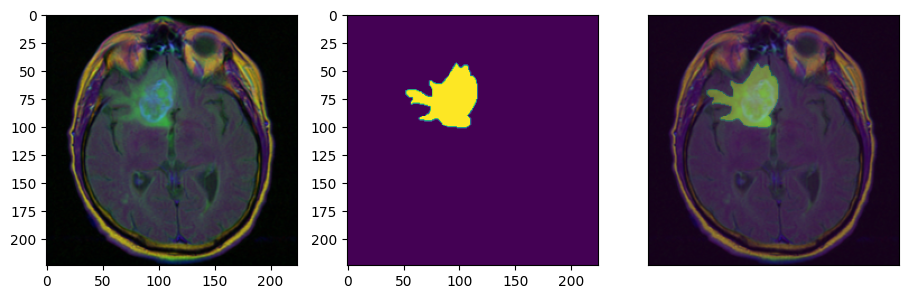

In [241]:
# входные данные должны быть размера (224, 224, 3) и (3, 224, 224)
im,m = next(x)
print(im.shape)
print(m.shape)
fig, ax = plt.subplots(1,3)
ax[0].imshow(im)
ax[1].imshow(m[2])
ax[2].imshow(im)
ax[2].imshow(m[2],alpha=0.3)
plt.xticks([]), plt.yticks([])
plt.show

In [224]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [225]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [226]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, weights=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(weights=weights).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [227]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    # print(preds.shape)
    # print(targets.shape)
    # print('----------------------')
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [228]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    # print(_masks.shape)
    # print(ce_masks.shape)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    # print('---------------')
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [229]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [242]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 0.032  trn_loss: 2.067  trn_acc: 0.572  (67.07s - 41880.98s remaining)

KeyboardInterrupt: 

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

In [ ]:
log.plot_epochs(['trn_acc','val_acc'])

In [ ]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)


subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])